In [1]:
import string
import sys
from collections import deque

import pandas as pd
import numpy as np
import altair as alt
alt.renderers.enable('mimetype')

from sklearn import datasets
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
import warnings

from catboost import CatBoostClassifier, CatBoostRegressor
from lightgbm.sklearn import LGBMClassifier, LGBMRegressor
from xgboost import XGBClassifier, XGBRegressor

from sklearn.utils import shuffle

warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

In [3]:
train_df = pd.read_csv("data/train.csv")

In [4]:
train_df.set_index('PassengerId', inplace=True)

In [5]:
train_df = shuffle(train_df)

In [6]:
train_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
519,1,2,"Angle, Mrs. William A (Florence ""Mary"" Agnes H...",female,36.0,1,0,226875,26.0000,NaN,S
68,0,3,"Crease, Mr. Ernest James",male,19.0,0,0,S.P. 3464,8.1583,NaN,S
108,1,3,"Moss, Mr. Albert Johan",male,NaN,0,0,312991,7.7750,NaN,S
227,1,2,"Mellors, Mr. William John",male,19.0,0,0,SW/PP 751,10.5000,NaN,S
775,1,2,"Hocking, Mrs. Elizabeth (Eliza Needs)",female,54.0,1,3,29105,23.0000,NaN,S


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 519 to 530
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [8]:
train_df.nunique()

Survived      2
Pclass        3
Name        891
Sex           2
Age          88
SibSp         7
Parch         7
Ticket      681
Fare        248
Cabin       147
Embarked      3
dtype: int64

# Data Wrangling

In [9]:
train_df['Survived'] = train_df['Survived'].astype(str)

In [10]:
train_df.loc[train_df['Pclass'] == 1, 'Pclass'] = "1st"
train_df.loc[train_df['Pclass'] == 2, 'Pclass'] = "2nd"
train_df.loc[train_df['Pclass'] == 3, 'Pclass'] = "3rd"
train_df['missing_Cabin'] = train_df['Cabin'].isna()
train_df['missing_Age'] = train_df['Age'].isna()
train_df.loc[train_df['Cabin'].isna(), 'Cabin'] = "missing"
train_df['Cabin'] = train_df['Cabin'].str.replace("^A{1}.*", "A")
train_df['Cabin'] = train_df['Cabin'].str.replace("^B{1}.*", "B")
train_df['Cabin'] = train_df['Cabin'].str.replace("^C{1}.*", "C")
train_df['Cabin'] = train_df['Cabin'].str.replace("^D{1}.*", "D")
train_df['Cabin'] = train_df['Cabin'].str.replace("^E{1}.*", "E")
train_df['Cabin'] = train_df['Cabin'].str.replace("^F{1}.*", "F")
train_df['Cabin'] = train_df['Cabin'].str.replace("^G{1}.*", "G")
train_df["n_Family"] = train_df["SibSp"] + train_df["Parch"] + 1
train_df

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,missing_Cabin,missing_Age,n_Family
PassengerId,,,,,,,,,,,,,,
519,1,2nd,"Angle, Mrs. William A (Florence ""Mary"" Agnes H...",female,36.0,1,0,226875,26.0000,missing,S,True,False,2
68,0,3rd,"Crease, Mr. Ernest James",male,19.0,0,0,S.P. 3464,8.1583,missing,S,True,False,1
108,1,3rd,"Moss, Mr. Albert Johan",male,NaN,0,0,312991,7.7750,missing,S,True,True,1
227,1,2nd,"Mellors, Mr. William John",male,19.0,0,0,SW/PP 751,10.5000,missing,S,True,False,1
775,1,2nd,"Hocking, Mrs. Elizabeth (Eliza Needs)",female,54.0,1,3,29105,23.0000,missing,S,True,False,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
679,0,3rd,"Goodwin, Mrs. Frederick (Augusta Tyler)",female,43.0,1,6,CA 2144,46.9000,missing,S,True,False,8
124,1,2nd,"Webber, Miss. Susan",female,32.5,0,0,27267,13.0000,E,S,False,False,1
688,0,3rd,"Dakic, Mr. Branko",male,19.0,0,0,349228,10.1708,missing,S,True,False,1


In [11]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 519 to 530
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Survived       891 non-null    object 
 1   Pclass         891 non-null    object 
 2   Name           891 non-null    object 
 3   Sex            891 non-null    object 
 4   Age            714 non-null    float64
 5   SibSp          891 non-null    int64  
 6   Parch          891 non-null    int64  
 7   Ticket         891 non-null    object 
 8   Fare           891 non-null    float64
 9   Cabin          891 non-null    object 
 10  Embarked       889 non-null    object 
 11  missing_Cabin  891 non-null    bool   
 12  missing_Age    891 non-null    bool   
 13  n_Family       891 non-null    int64  
dtypes: bool(2), float64(2), int64(3), object(7)
memory usage: 92.2+ KB


# EDA

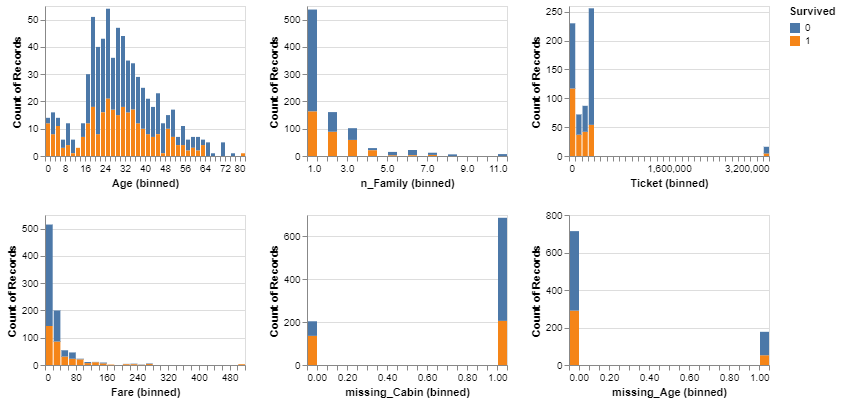

In [12]:
alt.Chart(train_df).mark_bar().encode(
    alt.X(alt.repeat(), type='quantitative', bin=alt.Bin(maxbins=40)),
    y='count()',
    fill='Survived'
).properties(
    width=200,
    height=150
).repeat(
    ['Age', 'n_Family', 'Ticket', 'Fare', 'missing_Cabin', 'missing_Age'],
    columns=3
)

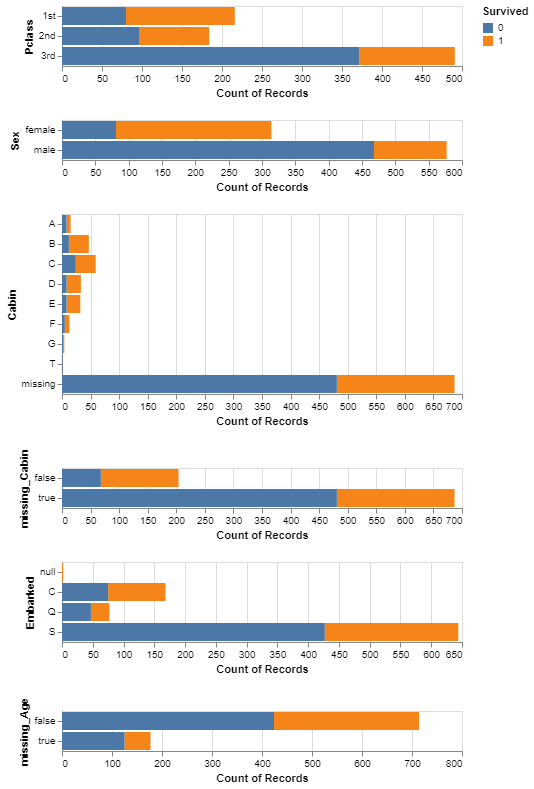

In [13]:
#Pclass, Sex, Cabin, Embarked

plot_pclass = alt.Chart(train_df).mark_bar().encode(
    y='Pclass',
    x='count()',
    fill='Survived'
)
plot_sex = alt.Chart(train_df).mark_bar().encode(
    y='Sex',
    x='count()',
    fill='Survived'
)
plot_cabin = alt.Chart(train_df).mark_bar().encode(
    x='count()',
    y='Cabin',
    fill='Survived'
)
plot_missing_cabin = alt.Chart(train_df).mark_bar().encode(
    x='count()',
    y='missing_Cabin',
    fill='Survived'
)
plot_embarked = alt.Chart(train_df).mark_bar().encode(
    y='Embarked',
    x='count()',
    fill='Survived'
)
plot_missing_age = alt.Chart(train_df).mark_bar().encode(
    x='count()',
    y='missing_Age',
    fill='Survived'
)

plot_pclass & plot_sex & plot_cabin & plot_missing_cabin & plot_embarked & plot_missing_age

In [14]:
X_train, y_train = train_df.drop(columns=['Survived']), train_df['Survived']

# Feature types

In [15]:
#"0" in list(X_train['Parch'])
#X_train['Parch'].nunique()

In [16]:
numeric_features = ["Age", "Fare", "n_Family"]
binary_features = ["Sex", "missing_Cabin", "missing_Age"]
ordinal_features = ["Pclass"]
ordering_ordinal = [
    ["3rd", "2nd", "1st"]
]
ticket_features = "Ticket"
categorical_features = ["Cabin", "Embarked"]
drop_features = ["Name", "SibSp", "Parch"]

In [17]:
ct = make_column_transformer(
    (
        make_pipeline(SimpleImputer(strategy='median'), StandardScaler()),
        numeric_features
    ),
    (
        OneHotEncoder(drop="if_binary", dtype=int, sparse=False), 
        binary_features
    ),
    (
        OrdinalEncoder(categories=ordering_ordinal),
        ordinal_features
    ),
    (
        CountVectorizer(ngram_range=(1, 3)),
        ticket_features
    ),
    (
        make_pipeline(
            SimpleImputer(strategy='most_frequent'),
            OneHotEncoder(handle_unknown="ignore")
        ), categorical_features
    ),
    ("drop", drop_features)
)



In [18]:
results = {}

In [19]:
pipe_dummy = make_pipeline(ct, DummyClassifier())

In [20]:
results["Dummy"] = mean_std_cross_val_scores(
    pipe_dummy, X_train, y_train, return_train_score=True
)

In [21]:
pd.DataFrame(results)

,Dummy
fit_time,0.020 (+/- 0.006)
score_time,0.009 (+/- 0.002)
test_score,0.616 (+/- 0.003)
train_score,0.616 (+/- 0.001)


# ML Models

In [22]:
pipe_dt = make_pipeline(ct, DecisionTreeClassifier(random_state=123))
pipe_svc = make_pipeline(ct, SVC(random_state=123))
pipe_rf = make_pipeline(ct, RandomForestClassifier(random_state=123))
pipe_xgb = make_pipeline(ct, XGBClassifier(random_state=123, verbosity=0))
pipe_lgbm = make_pipeline(ct, LGBMClassifier(random_state=123))
pipe_catb = make_pipeline(ct, CatBoostClassifier(random_state=123, verbose=0))

In [23]:
models = {
    "decision_tree": pipe_dt,
    "SVC": pipe_svc,
    "random_forest": pipe_rf,
    "XGBoost": pipe_xgb,
    "LightGBM": pipe_lgbm,
    "CatBoost": pipe_catb
}

In [24]:
for (name, model) in models.items():
    results[name] = mean_std_cross_val_scores(
        model, X_train, y_train, return_train_score=True
    )

C:\Users\johnw\miniconda3\envs\573\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\johnw\miniconda3\envs\573\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\johnw\miniconda3\envs\573\lib\site-packages\xgboost\sklearn.py:88

In [25]:
pd.DataFrame(results)

,Dummy,decision_tree,SVC,random_forest,XGBoost,LightGBM,CatBoost
fit_time,0.020 (+/- 0.006),0.022 (+/- 0.002),0.031 (+/- 0.001),0.208 (+/- 0.005),0.160 (+/- 0.007),0.065 (+/- 0.005),3.047 (+/- 0.028)
score_time,0.009 (+/- 0.002),0.007 (+/- 0.000),0.010 (+/- 0.001),0.019 (+/- 0.001),0.014 (+/- 0.000),0.012 (+/- 0.001),0.011 (+/- 0.001)
test_score,0.616 (+/- 0.003),0.831 (+/- 0.019),0.822 (+/- 0.026),0.827 (+/- 0.021),0.818 (+/- 0.023),0.828 (+/- 0.015),0.833 (+/- 0.015)
train_score,0.616 (+/- 0.001),0.999 (+/- 0.001),0.857 (+/- 0.003),0.999 (+/- 0.001),0.978 (+/- 0.002),0.956 (+/- 0.004),0.871 (+/- 0.007)


In [26]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 519 to 530
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Pclass         891 non-null    object 
 1   Name           891 non-null    object 
 2   Sex            891 non-null    object 
 3   Age            714 non-null    float64
 4   SibSp          891 non-null    int64  
 5   Parch          891 non-null    int64  
 6   Ticket         891 non-null    object 
 7   Fare           891 non-null    float64
 8   Cabin          891 non-null    object 
 9   Embarked       889 non-null    object 
 10  missing_Cabin  891 non-null    bool   
 11  missing_Age    891 non-null    bool   
 12  n_Family       891 non-null    int64  
dtypes: bool(2), float64(2), int64(3), object(6)
memory usage: 85.3+ KB


In [42]:
X_test = pd.read_csv("data/test.csv")
X_test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [43]:
X_test.loc[X_test['Pclass'] == 1, 'Pclass'] = "1st"
X_test.loc[X_test['Pclass'] == 2, 'Pclass'] = "2nd"
X_test.loc[X_test['Pclass'] == 3, 'Pclass'] = "3rd"
X_test['missing_Cabin'] = X_test['Cabin'].isna()
X_test['missing_Age'] = X_test['Age'].isna()
X_test.loc[X_test['Cabin'].isna(), 'Cabin'] = "missing"
X_test['Cabin'] = X_test['Cabin'].str.replace("^A{1}.*", "A")
X_test['Cabin'] = X_test['Cabin'].str.replace("^B{1}.*", "B")
X_test['Cabin'] = X_test['Cabin'].str.replace("^C{1}.*", "C")
X_test['Cabin'] = X_test['Cabin'].str.replace("^D{1}.*", "D")
X_test['Cabin'] = X_test['Cabin'].str.replace("^E{1}.*", "E")
X_test['Cabin'] = X_test['Cabin'].str.replace("^F{1}.*", "F")
X_test['Cabin'] = X_test['Cabin'].str.replace("^G{1}.*", "G")
X_test["n_Family"] = X_test["SibSp"] + X_test["Parch"] + 1
X_test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,missing_Cabin,missing_Age,n_Family
0,892,3rd,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,missing,Q,True,False,1
1,893,3rd,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,missing,S,True,False,2
2,894,2nd,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,missing,Q,True,False,1
3,895,3rd,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,missing,S,True,False,1
4,896,3rd,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,missing,S,True,False,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3rd,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,missing,S,True,True,1
414,1306,1st,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C,C,False,False,1
415,1307,3rd,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,missing,S,True,False,1
416,1308,3rd,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,missing,S,True,True,1


In [44]:
pipe_dt.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Fare', 'n_Family']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                dtype=<class 'int'>,
                                                                sparse=False),
                                                  ['Sex', 'missing_Cabin',
                                                   'missing_Age']),
   

In [45]:
prediction = pipe_dt.predict(X_test)

In [46]:
X_test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,missing_Cabin,missing_Age,n_Family
0,892,3rd,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,missing,Q,True,False,1
1,893,3rd,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,missing,S,True,False,2
2,894,2nd,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,missing,Q,True,False,1
3,895,3rd,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,missing,S,True,False,1
4,896,3rd,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,missing,S,True,False,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3rd,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,missing,S,True,True,1
414,1306,1st,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C,C,False,False,1
415,1307,3rd,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,missing,S,True,False,1
416,1308,3rd,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,missing,S,True,True,1


In [47]:
X_test = X_test.drop(
    columns = [
        "Pclass", "Name", "Sex", "Age", "SibSp", "Parch", "Ticket", "Fare", 
        "Cabin", "Embarked", "missing_Cabin", "missing_Age", "n_Family"
    ]
)
X_test

,PassengerId
0,892
1,893
2,894
3,895
4,896
...,...
413,1305
414,1306
415,1307
416,1308


In [48]:
X_test["Survived"] = prediction
X_test

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [49]:
X_test.to_csv("titanic_result_DecTree.csv", encoding='utf-8', index=False)